<a href="https://colab.research.google.com/github/natskiu/Nasa-Battery/blob/main/Data_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#this is a comment
import scipy.io as sio

In [2]:
# raw=true is important so you download the file rather than the webpage.
!wget https://github.com/natskiu/Nasa-Battery/blob/main/Data/B0005.mat?raw=true
# rename the file
!mv B0005.mat\?raw\=true B0005.mat
# update scipy
!pip install -U -q scipy
# Load the data
from scipy import io
v = io.loadmat('B0005.mat')

--2021-08-17 03:00:56--  https://github.com/natskiu/Nasa-Battery/blob/main/Data/B0005.mat?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/natskiu/Nasa-Battery/raw/main/Data/B0005.mat [following]
--2021-08-17 03:00:56--  https://github.com/natskiu/Nasa-Battery/raw/main/Data/B0005.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/natskiu/Nasa-Battery/main/Data/B0005.mat [following]
--2021-08-17 03:00:56--  https://raw.githubusercontent.com/natskiu/Nasa-Battery/main/Data/B0005.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

In [4]:
v.keys()

dict_keys(['__header__', '__version__', '__globals__', 'B0005'])

In [7]:
np.vstack(v['B0005'][0,0]).shape

(1, 616)

In [9]:
"only change the middle index i.e. cycles[0,1][3], cycles[0,2][3]"
cycles[0,0][3].shape

(1, 1)

In [3]:
# important!!!
cycles = np.vstack(v['B0005'][0,0])
cycles.shape

(1, 616)

In [9]:
def capacity_vectorizer(discharge_indices, cycles=cycles):
  """
  inputs
  -------------------
  discharge_indicies: list, with indices of discharging cycles

  outputs
  -------------------
  None (modifies cycles)

  Note: only run this function ONCE
  """
  for discharge_index in discharge_indices:
    N = (cycles[0,discharge_index][3][0,0][5]).shape[1] # gets number of entries
    capacity_scalar = cycles[0,discharge_index][3][0,0][6]
    cycles[0,discharge_index][3][0,0][6] = np.pad(capacity_scalar.flatten().tolist(), (0, N-1), 'constant')
    vectorized_cycles = cycles
  return vectorized_cycles


In [10]:
def get_indices(cycles, is_charge=True):
  index_list =[]
  if is_charge:
    label = 'charge'
  else:
    label = 'discharge'
  for i in range(cycles.shape[1]):
    if cycles[0,i][0] == np.array([label], dtype='<U9'):
      index_list.append(i)

  return index_list

In [11]:
discharge_indices = get_indices(cycles, is_charge = False)
print(discharge_indices)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 135, 139, 143, 147, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 215, 219, 223, 227, 231, 235, 239, 243, 247, 251, 255, 259, 263, 265, 269, 273, 277, 281, 285, 289, 293, 297, 301, 305, 309, 312, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 366, 370, 374, 378, 382, 386, 390, 394, 398, 402, 406, 410, 414, 418, 422, 426, 430, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 482, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 547, 551, 555, 559, 563, 567, 571, 575, 579, 583, 587, 591, 595, 599, 603, 607, 611, 613]


In [ ]:
"This is how you extract all the features from cycles"
np.vstack(cycles[0,0][3][0,0])[0]

In [12]:
new_cycles = capacity_vectorizer(discharge_indices)

In [14]:
new_cycles[0,1][3][0,0][6].shape

(197,)

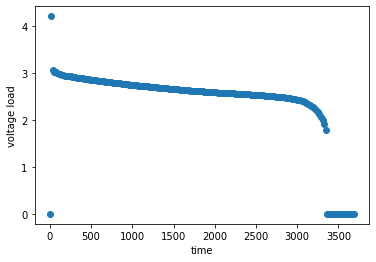

In [16]:
y = np.vstack(new_cycles[0,1][3][0,0])[4]
x = np.vstack(new_cycles[0,1][3][0,0])[5]
plt.ylabel('voltage load')
plt.xlabel('time')
plt.scatter(x, y)

In [36]:
np.vstack(new_cycles[0,1][3][0,0])[2]

array([24.33003389, 24.32599342, 24.38908513, 24.54475232, 24.7313852 ,
       24.9098164 , 25.10588415, 25.31701856, 25.5094231 , 25.70360345,
       25.88720819, 26.07781486, 26.25431462, 26.43671069, 26.61127891,
       26.78134765, 26.95745885, 27.12980014, 27.30582408, 27.46481668,
       27.61796452, 27.77547783, 27.93132998, 28.07896948, 28.2335031 ,
       28.37877941, 28.5225242 , 28.66589833, 28.81671829, 28.93274894,
       29.0704461 , 29.18458627, 29.29244411, 29.40274581, 29.4989651 ,
       29.59370293, 29.68142827, 29.76670142, 29.83908101, 29.91087573,
       29.98224432, 30.03264278, 30.09435785, 30.1385033 , 30.18676402,
       30.23782919, 30.28051474, 30.33483731, 30.3862846 , 30.42258867,
       30.47429007, 30.52163904, 30.56564256, 30.61434254, 30.65539856,
       30.70351241, 30.75861687, 30.80590866, 30.8597146 , 30.91010409,
       30.9551582 , 31.00631131, 31.06151883, 31.12140149, 31.16242581,
       31.22480654, 31.27691155, 31.32902135, 31.37758384, 31.43

In [45]:
def cycle_plotter(cycle_index):
  features = ['voltage_measured', 'currenet_measured', 'temperature', 'current_load/charge', 'voltage_load/charge']
  for i, label in enumerate(features):
    y = np.vstack(new_cycles[0,cycle_index][3][0,0])[i]
    x = np.vstack(new_cycles[0,cycle_index][3][0,0])[5]
    f=plt.figure()
    plt.ylabel(label)
    plt.xlabel('time')
    plt.title(label)
    plt.scatter(x, y)
  plt.show()

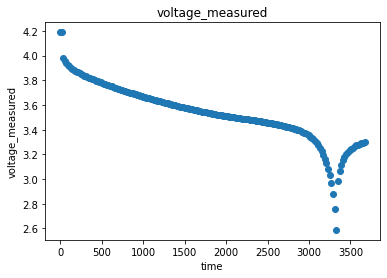

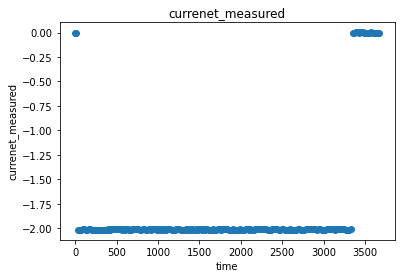

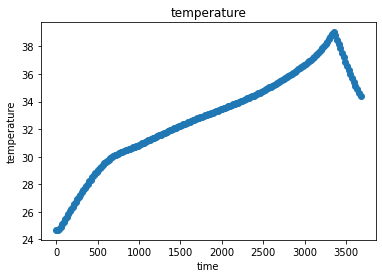

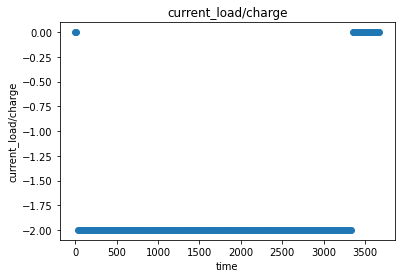

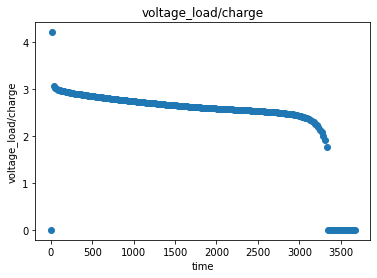

In [56]:
cycle_plotter(3) #Discharging cycle

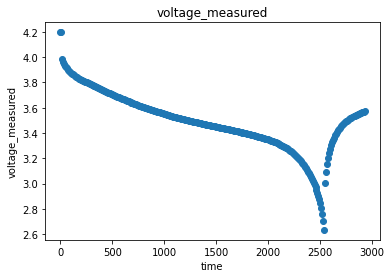

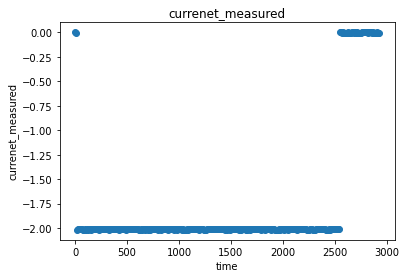

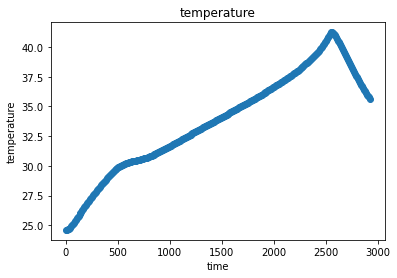

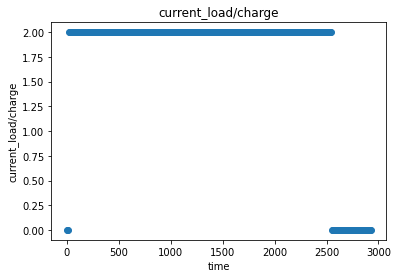

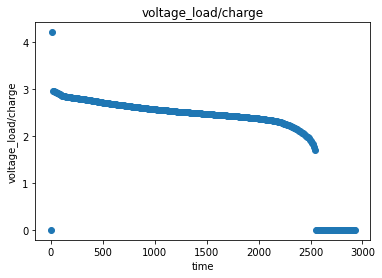

In [55]:
cycle_plotter(422)

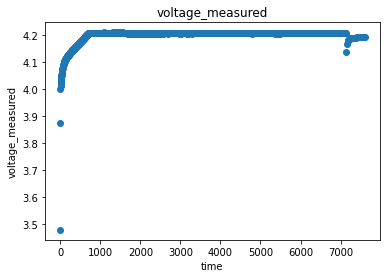

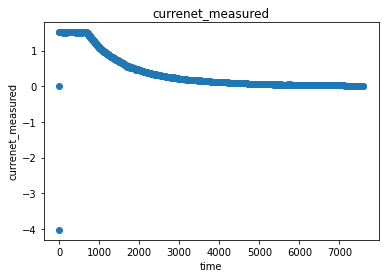

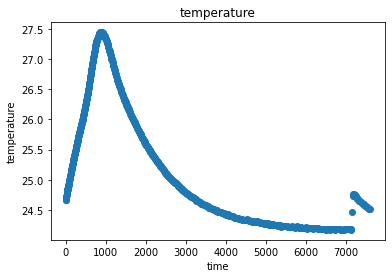

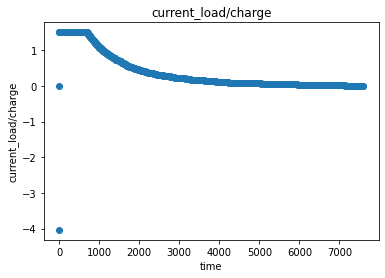

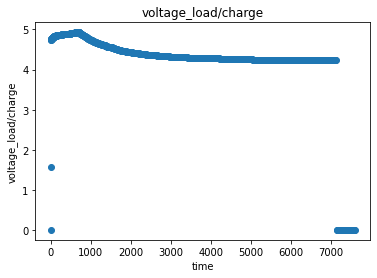

In [54]:
cycle_plotter(0)

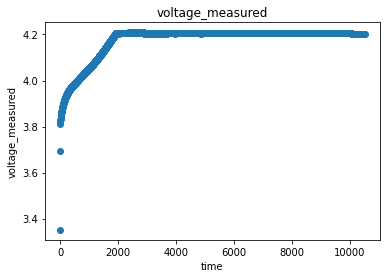

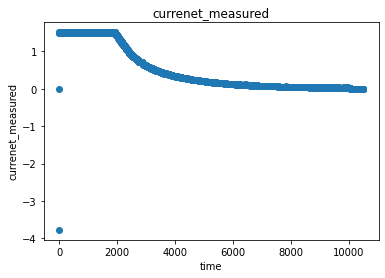

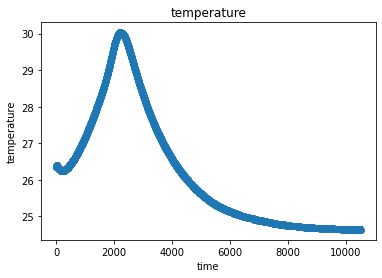

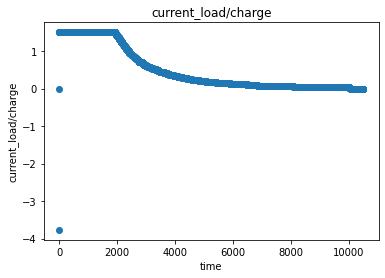

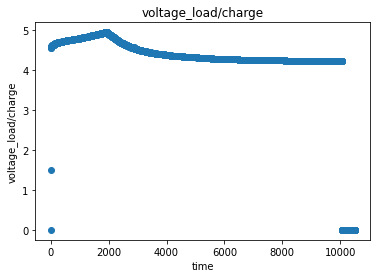

In [53]:
cycle_plotter(420) #charging cycle